In [16]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
image_path = "/content/drive/MyDrive/Colab Notebooks/CFL_training_data"

In [18]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(image_path, 'input_wall'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input_wall', image)), (256,256)))
  output_image_path = os.path.join(image_path, 'output_wall', image).replace('.jpg', '.png')
  output_images.append(cv2.resize(cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

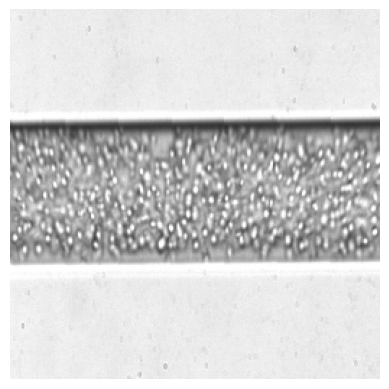

(256, 256, 3)


In [19]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

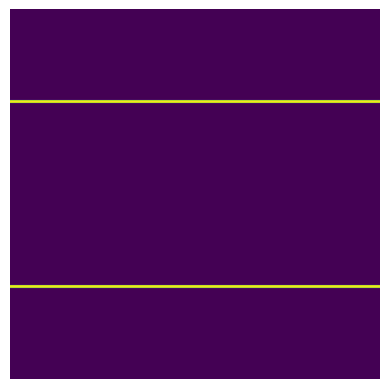

(256, 256, 1)


In [20]:
plt.imshow(output_images[1])
plt.axis('off')
plt.show()
print(output_images[0].shape)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [22]:
def unet_plus_plus(input_shape=(256, 256, 3), num_filters=64):
    inputs = Input(input_shape)

    # Downsampling
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv_block(p4, num_filters * 16)

    # Upsampling
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = conv_block(u9, num_filters)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    #model = Model(inputs=[inputs], outputs=[outputs], name = "U-Net++")
    model = Model(inputs=[inputs], outputs=[outputs], name="U_Net_Plus_Plus")


    return model


In [23]:
model = unet_plus_plus()
model.summary()

Model: "U_Net_Plus_Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_normaliz

In [24]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=['binary_accuracy'])
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    shuffle=False)

Epoch 1/30
100/100 [==============================] - 89s 766ms/step - loss: 0.3564 - binary_accuracy: 0.9265 - val_loss: 0.4193 - val_binary_accuracy: 0.9763
Epoch 2/30
100/100 [==============================] - 75s 753ms/step - loss: 0.1744 - binary_accuracy: 0.9835 - val_loss: 0.3298 - val_binary_accuracy: 0.9503
Epoch 3/30
100/100 [==============================] - 75s 752ms/step - loss: 0.1350 - binary_accuracy: 0.9837 - val_loss: 0.1303 - val_binary_accuracy: 0.9792
Epoch 4/30
100/100 [==============================] - 76s 756ms/step - loss: 0.1102 - binary_accuracy: 0.9837 - val_loss: 0.1148 - val_binary_accuracy: 0.9799
Epoch 5/30
100/100 [==============================] - 76s 759ms/step - loss: 0.0948 - binary_accuracy: 0.9844 - val_loss: 0.1051 - val_binary_accuracy: 0.9822
Epoch 6/30
100/100 [==============================] - 75s 752ms/step - loss: 0.0838 - binary_accuracy: 0.9856 - val_loss: 0.1011 - val_binary_accuracy: 0.9816
Epoch 7/30
100/100 [==========================

In [25]:
model.save(os.path.join(image_path, 'unet_plus_plus_wall.hdf5'))

In [26]:
# Predicting on the first 5 images
pred = model.predict(np.array(input_images[:5]))

1/1 [==============================] - 0s 408ms/step


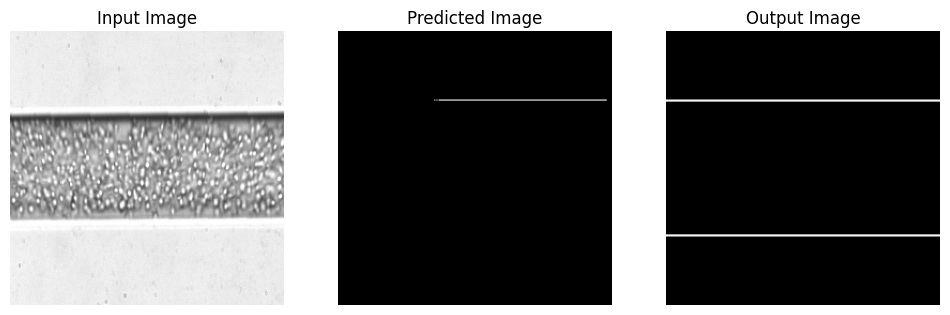

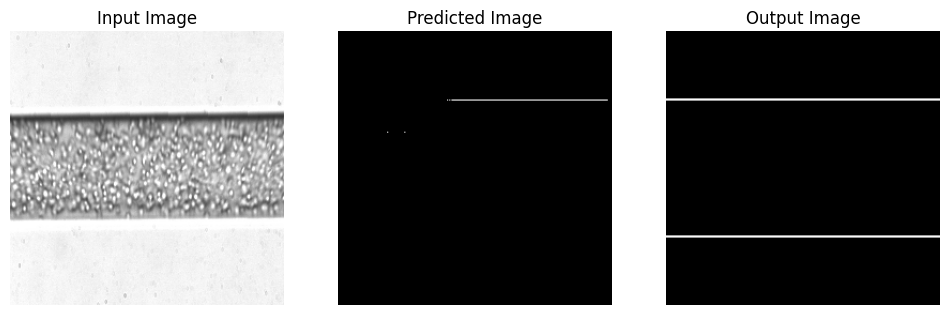

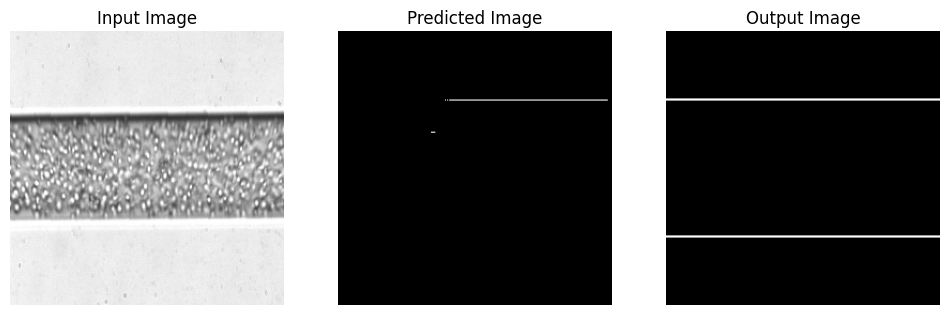

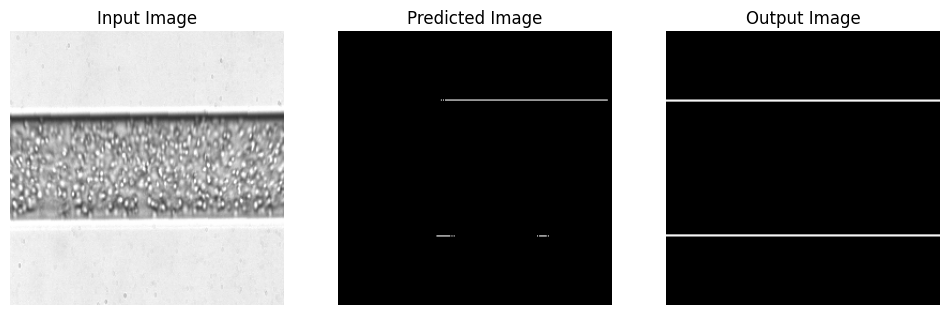

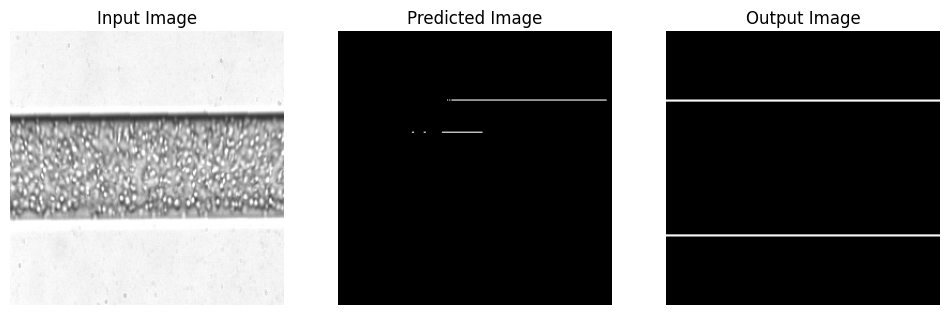

In [30]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_images[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(pred[i]>0.9, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(output_images[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()

In [28]:
# Calculate the index for the validation split
validation_split = 0.2
split_index = int(len(input_images) * (1 - validation_split))

val_input_images = input_images[split_index:split_index + 5]
val_output_images = output_images[split_index:split_index + 5]

val_input = np.array(val_input_images)
val_output = np.array(val_output_images)

val_pred = model.predict(val_input)

1/1 [==============================] - 0s 20ms/step


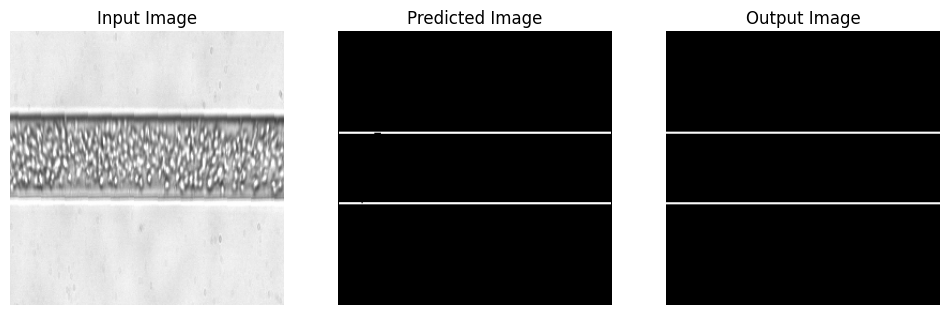

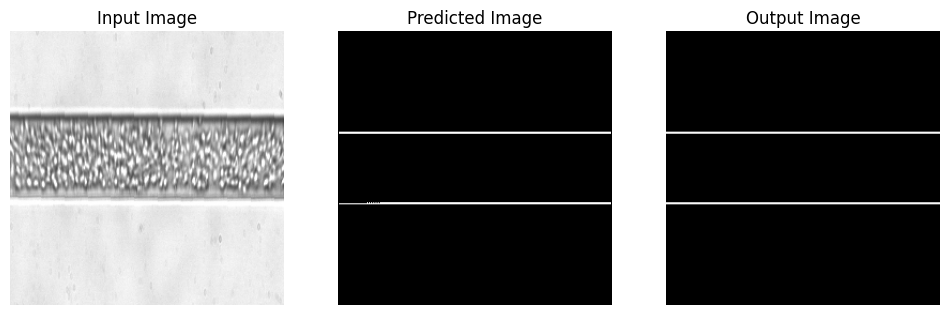

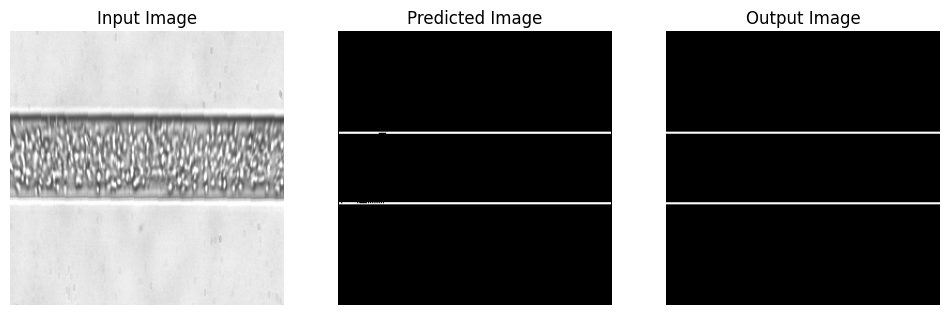

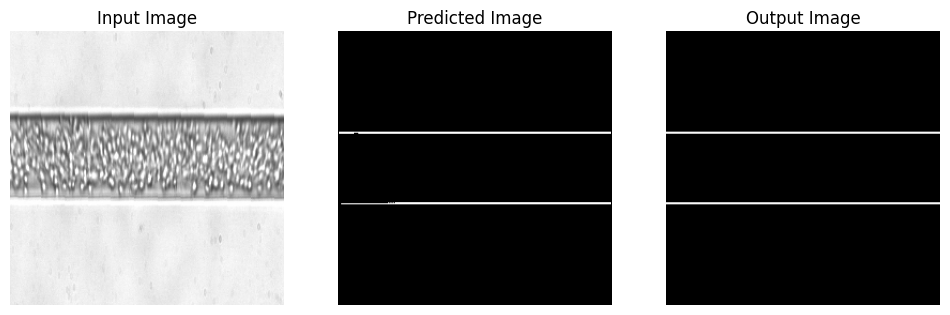

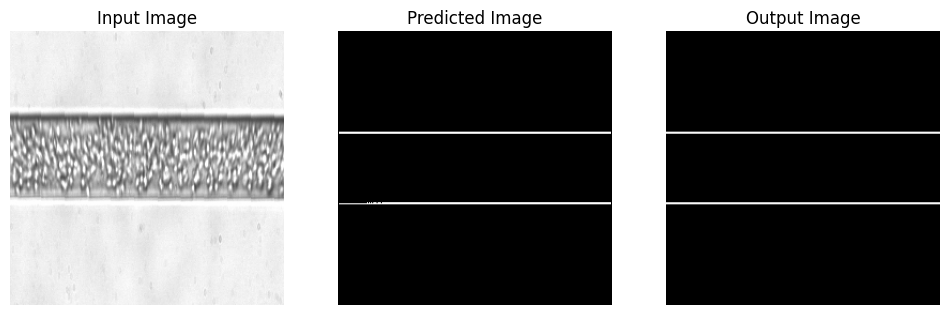

In [29]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(val_input[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(val_pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(val_output[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()